# FASE 1

In [20]:
# --- Importación de Librerías ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

In [21]:
# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [22]:
# --- 1. Carga y Descripción del Conjunto de Datos ---

# Cargar el dataset (asegúrate de que este archivo esté en el mismo directorio)
try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print("Dataset cargado exitosamente.")
except FileNotFoundError:
    print("Error: No se encontró el archivo 'WA_Fn-UseC_-Telco-Customer-Churn.csv'.")
    # En un notebook, aquí detendrías la ejecución o manejarías el error
    df = pd.DataFrame() # Crear un DF vacío para evitar errores posteriores

if not df.empty:
    print("\n--- 1.1. Vista Inicial de los Datos (Head) ---")
    print(df.head())

    print("\n--- 1.2. Información y Tipos de Datos (Info) ---")
    df.info()

    print("\n--- 1.3. Limpieza Inicial ---")
    
    # Eliminar customerID, ya que no es un feature predictivo
    if 'customerID' in df.columns:
        df = df.drop('customerID', axis=1)
        print("Columna 'customerID' eliminada.")

    # Convertir TotalCharges a numérico
    # Contiene espacios en blanco que causan que sea 'object'
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    
    # Verificar NaNs (creados por la coerción de 'TotalCharges')
    print("\nValores Nulos (antes de imputar TotalCharges):")
    print(df.isnull().sum())

    # Imputar los NaNs en TotalCharges. 
    # Los NaNs (11) corresponden a clientes con 'tenure' = 0, por lo que imputar con 0 es razonable.
    df['TotalCharges'] = df['TotalCharges'].fillna(0)
    print("\nValores Nulos (después de imputar TotalCharges):")
    print(df.isnull().sum())

Dataset cargado exitosamente.

--- 1.1. Vista Inicial de los Datos (Head) ---
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...      


--- 2.1. EDA: Variable Objetivo (Churn) ---


C:\Users\yuden\AppData\Local\Temp\ipykernel_34696\1622678943.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churn', palette='pastel')


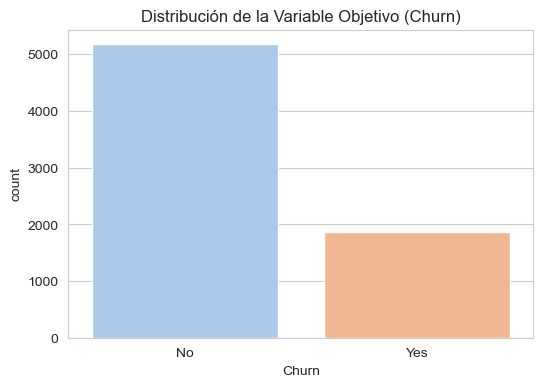

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64
Comentario: El dataset está desbalanceado. 'No' (No Churn) es mucho más frecuente que 'Yes' (Churn).

--- 2.2. EDA: Variables Categóricas vs. Churn ---


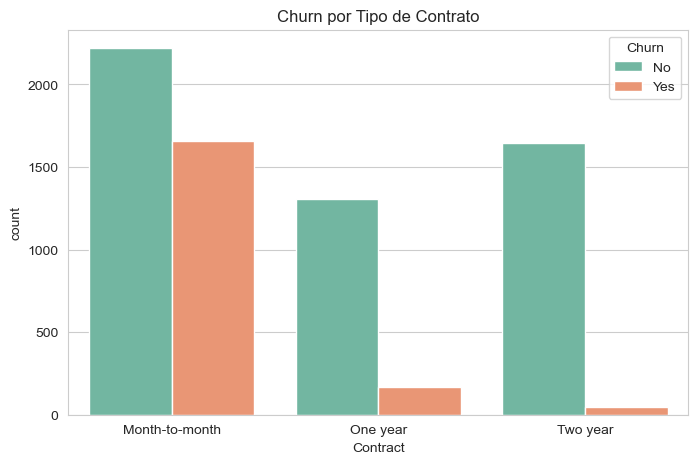

Comentario: Los clientes con contrato 'Month-to-month' tienen una tasa de abandono mucho mayor.


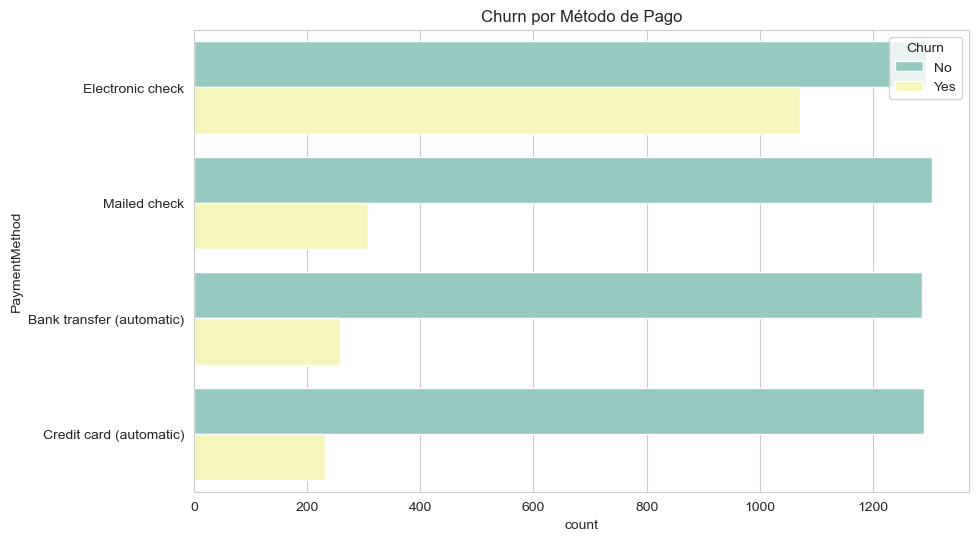


--- 2.3. EDA: Variables Numéricas vs. Churn ---


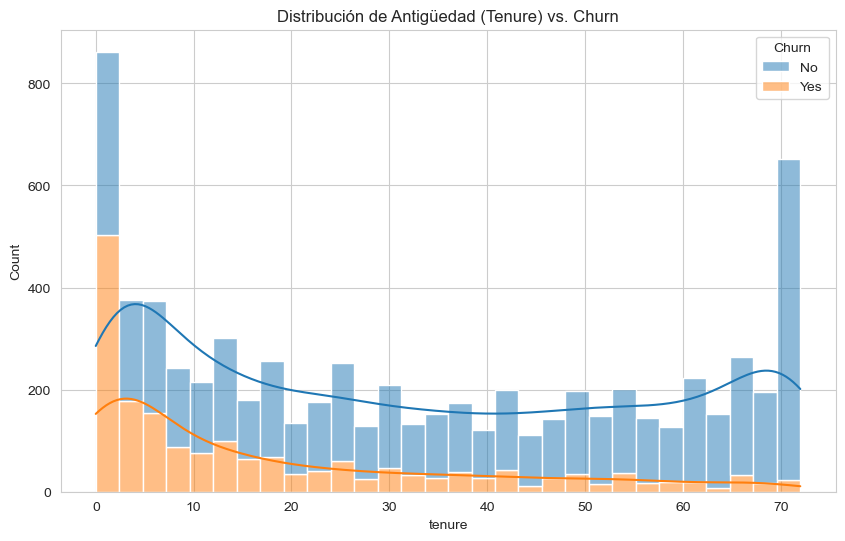

Comentario: El Churn es mucho más alto en los primeros meses (baja antigüedad).


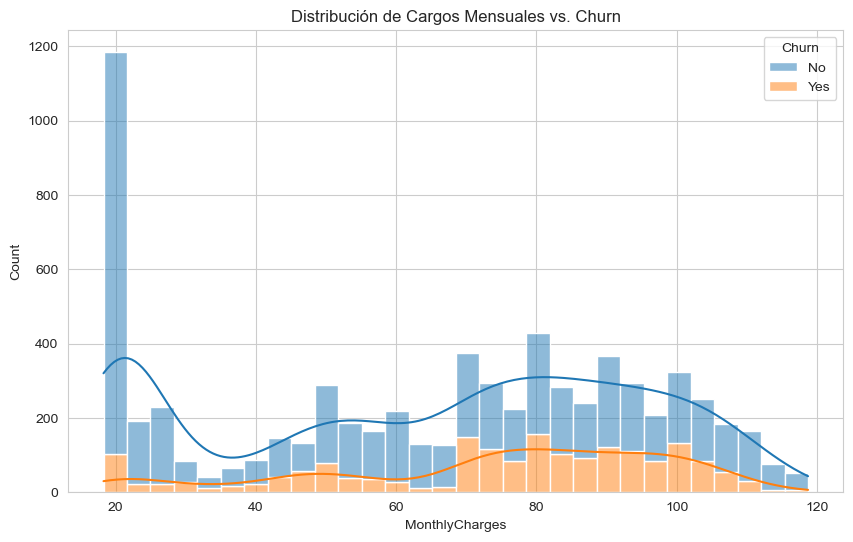

In [23]:
# --- 2. Análisis Exploratorio de Datos (EDA) ---

if not df.empty:
    print("\n--- 2.1. EDA: Variable Objetivo (Churn) ---")
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x='Churn', palette='pastel')
    plt.title('Distribución de la Variable Objetivo (Churn)')
    plt.show()
    print(df['Churn'].value_counts(normalize=True))
    print("Comentario: El dataset está desbalanceado. 'No' (No Churn) es mucho más frecuente que 'Yes' (Churn).")

    print("\n--- 2.2. EDA: Variables Categóricas vs. Churn ---")
    
    # Gráfico: Churn por Tipo de Contrato
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='Contract', hue='Churn', palette='Set2')
    plt.title('Churn por Tipo de Contrato')
    plt.show()
    print("Comentario: Los clientes con contrato 'Month-to-month' tienen una tasa de abandono mucho mayor.")

    # Gráfico: Churn por Método de Pago
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, y='PaymentMethod', hue='Churn', palette='Set3')
    plt.title('Churn por Método de Pago')
    plt.show()

    print("\n--- 2.3. EDA: Variables Numéricas vs. Churn ---")
    
    # Gráfico: Churn por Antigüedad (Tenure)
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', kde=True, bins=30)
    plt.title('Distribución de Antigüedad (Tenure) vs. Churn')
    plt.show()
    print("Comentario: El Churn es mucho más alto en los primeros meses (baja antigüedad).")

    # Gráfico: Churn por Cargos Mensuales (MonthlyCharges)
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack', kde=True, bins=30)
    plt.title('Distribución de Cargos Mensuales vs. Churn')
    plt.show()

In [24]:
# --- 3. Transformación de Variables (Preprocesamiento) ---

if not df.empty:
    print("\n--- 3.1. Preparando Datos para el Modelo ---")

    # Copia para preprocesamiento
    df_model = df.copy()

    # --- 3.1.1. Codificar Variable Objetivo (Target) ---
    target_col = 'Churn'
    target_le = LabelEncoder()
    y = target_le.fit_transform(df_model[target_col])
    print(f"Variable objetivo '{target_col}' codificada: {list(target_le.classes_)} -> {target_le.transform(target_le.classes_)}")
    
    X = df_model.drop(target_col, axis=1)

    # --- 3.1.2. Identificar Tipos de Features ---
    # Numéricas
    numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
    
    # Categóricas
    # SeniorCitizen es 0/1 pero tipo int, la tratamos como categórica binaria.
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    categorical_cols.append('SeniorCitizen')

    print(f"\nColumnas Numéricas (a escalar): {numerical_cols}")
    print(f"Columnas Categóricas (a codificar): {categorical_cols}")

    # --- 3.1.3. Codificar Categóricas Binarias (LabelEncoder) ---
    binary_cols = [col for col in categorical_cols if X[col].nunique() == 2]
    
    label_encoders = {}
    for col in binary_cols:
        # SeniorCitizen ya es 0/1, no necesita LE.
        if col != 'SeniorCitizen': 
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            label_encoders[col] = le
            print(f"'{col}' codificada con LabelEncoder.")

    # --- 3.1.4. Codificar Categóricas Multiclase (One-Hot Encoding) ---
    multi_class_cols = [col for col in categorical_cols if col not in binary_cols]
    
    print(f"\nAplicando One-Hot Encoding a: {multi_class_cols}")
    X = pd.get_dummies(X, columns=multi_class_cols, drop_first=True)
    
    print(f"Dimensiones de X después de OHE: {X.shape}")

    # --- 3.1.5. Escalar Features Numéricas ---
    scaler = MinMaxScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    print("Columnas numéricas escaladas con MinMaxScaler.")
    
    print("\n--- 3.2. Head de Datos Preprocesados (X) ---")
    print(X.head())

    # --- 3.3. Partición de Datos (Train/Valid/Test) ---
    # 
    
    # Partición principal: 80% Entrenamiento (full), 20% Prueba
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y # Estratificar por Churn
    )

    # Sub-partición: 80% Train (del 80% original), 20% Validación (del 80% original)
    # Esto resulta en 64% Train, 16% Valid, 20% Test del total.
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        test_size=0.2, # 0.2 del X_train_full (que es 80% del total)
        random_state=42,
        stratify=y_train_full
    )

    print("\n--- 3.4. Dimensiones de los Conjuntos de Datos ---")
    print(f"Forma de X_train (para KerasTuner/PyTorch): {X_train.shape}")
    print(f"Forma de y_train: {y_train.shape}")
    print(f"Forma de X_val (para KerasTuner/PyTorch): {X_val.shape}")
    print(f"Forma de y_val: {y_val.shape}")
    print(f"Forma de X_test (para Evaluación Final): {X_test.shape}")
    print(f"Forma de y_test: {y_test.shape}")

    # (Opcional) Guardar los datos preprocesados para las siguientes fases
    # np.save('X_train.npy', X_train)
    # np.save('y_train.npy', y_train)
    # np.save('X_val.npy', X_val)
    # np.save('y_val.npy', y_val)
    # np.save('X_test.npy', X_test)
    # np.save('y_test.npy', y_test)
    # pd.to_pickle(scaler, 'scaler.pkl')
    # pd.to_pickle(label_encoders, 'label_encoders.pkl')
    # pd.to_pickle(X.columns, 'processed_columns.pkl')

    print("\nFase 1 (EDA y Preprocesamiento) completada.")

else:
    print("\nNo se pudo cargar el DataFrame, se omiten los pasos de EDA y Preprocesamiento.")


--- 3.1. Preparando Datos para el Modelo ---
Variable objetivo 'Churn' codificada: ['No', 'Yes'] -> [0 1]

Columnas Numéricas (a escalar): ['tenure', 'MonthlyCharges', 'TotalCharges']
Columnas Categóricas (a codificar): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']
'gender' codificada con LabelEncoder.
'Partner' codificada con LabelEncoder.
'Dependents' codificada con LabelEncoder.
'PhoneService' codificada con LabelEncoder.
'PaperlessBilling' codificada con LabelEncoder.

Aplicando One-Hot Encoding a: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
Dimensiones de X después de OHE: (7043, 30)
Columnas numéricas escaladas con MinMaxScaler.

--- 3.2. Head de Da